###  Motivation
- The data comes from renthop.com, an apartment listing website.  
- Predict how popular(high/medium/low) an apartment rental listing is based on the listing content like text description, photos, number of bedrooms, price, etc.

### Outline
- Explore Data
  1. Generate new feactures
  2. Data visualization 
- Model Building
  1. Based Model: XGboost, Neural Network, Random Forest, KNN, Logistic Regression
  2. Ensemble Model: Voting 

In [1]:
import os
import sys
import operator
import numpy as np
import pandas as pd
from scipy import sparse
import xgboost as xgb
import random
from sklearn import model_selection, preprocessing, ensemble
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

C:\Users\amyhu\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
train_df=pd.read_json('C://Users//amyhu//Google Drive//CPE 695//kagg//train.json//train.json')
test_df=pd.read_json('C://Users//amyhu//Google Drive//CPE 695//kagg//test.json//test.json')

#train_df=pd.read_json('C://Users//hp//Google Drive//CPE 695//kagg//train.json//train.json')
#test_df=pd.read_json('C://Users//hp//Google Drive//CPE 695//kagg//test.json//test.json')

### Explore Data

In [74]:
pd.DataFrame({"01.bathrooms":['Numerical'],
             "02.bedrooms ":['Numerical'],
             "14.building_id":['Categorical'],
             "04.created":['Date'],
             "05.description":['Text'],
             "06.display_address":['Text'],
             "07.features": ['Text'],
             "08.interest_level ":['Categorical'],
             '09.latitude':['Numerical'],
             '10.listing_id':['Categorical'],
             '11.longitude':['Numerical'],
             '12.manager_id':['Categorical'],
             '13.photos':['Pictures'],
             '2.price':['Numerical'],
             '15.street_address':['Text']})

,01.bathrooms,02.bedrooms,04.created,05.description,06.display_address,07.features,08.interest_level,09.latitude,10.listing_id,11.longitude,12.manager_id,13.photos,14.building_id,15.street_address,2.price
0,Numerical,Numerical,Date,Text,Text,Text,Categorical,Numerical,Categorical,Numerical,Categorical,Pictures,Categorical,Text,Numerical


In [5]:
train_df.isnull().sum()

bathrooms          0
bedrooms           0
building_id        0
created            0
description        0
display_address    0
features           0
interest_level     0
latitude           0
listing_id         0
longitude          0
manager_id         0
photos             0
price              0
street_address     0
dtype: int64

In [6]:
#basic features
train_df["price_t"] =train_df["price"]/train_df["bedrooms"]
test_df["price_t"] = test_df["price"]/test_df["bedrooms"] 
train_df["room_sum"] = train_df["bedrooms"]+train_df["bathrooms"] 
test_df["room_sum"] = test_df["bedrooms"]+test_df["bathrooms"] 

# count of photos #
train_df["num_photos"] = train_df["photos"].apply(len)
test_df["num_photos"] = test_df["photos"].apply(len)

# count of "features" #
train_df["num_features"] = train_df["features"].apply(len)
test_df["num_features"] = test_df["features"].apply(len)

# count of words present in description column #
train_df["num_description_words"] = train_df["description"].apply(lambda x: len(x.split(" ")))
test_df["num_description_words"] = test_df["description"].apply(lambda x: len(x.split(" ")))


features_to_use=["bathrooms", "bedrooms", "latitude", "longitude", "price","price_t","num_photos", "num_features", "num_description_words","listing_id"]

In [58]:
pd.DataFrame({"01.bathrooms":['Numerical'],
                        "02.bedrooms ":['Numerical'],
                         "14.building_id":['Categorical'],
                         "04.created":['Date'],
                         "05.description":['Text'],
                         "06.display_address":['Text'],
                         "07.features": ['Text'],
                         "08.interest_level ":['Categorical'],
             '09.latitude':['Numerical'],
             '10.listing_id':['Categorical'],
             '11.longitude':['Numerical'],
             '12.manager_id':['Categorical'],
             '13.photos':['Pictures'],
             '2.price':['Numerical'],
             '15.street_address':['Text'],
             '001.price/room':['Numerical'],
             '002.number of rooms':['Numerical'],
             '003.number of pictures':['Numerical'],
             '004.number of features':['Numerical'],
             '005.number of words in description':['Numerical'],})

,001.price/room,002.number of rooms,003.number of pictures,004.number of features,005.number of words in description,01.bathrooms,02.bedrooms,04.created,05.description,06.display_address,07.features,08.interest_level,09.latitude,10.listing_id,11.longitude,12.manager_id,13.photos,14.building_id,15.street_address,2.price
0,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,Date,Text,Text,Text,Categorical,Numerical,Categorical,Numerical,Categorical,Pictures,Categorical,Text,Numerical


In [7]:
index=list(range(train_df.shape[0]))
random.shuffle(index)
a=[0]*len(train_df)
b=[0]*len(train_df)
c=[0]*len(train_df)

for i in range(5):
    building_level={}
    for j in train_df['manager_id'].values:
        building_level[j]=[0,0,0]
    test_index=index[int((i*train_df.shape[0])/5):int(((i+1)*train_df.shape[0])/5)]
    train_index=list(set(index).difference(test_index))
    for j in train_index:
        temp=train_df.iloc[j]
        if temp['interest_level']=='low':
            building_level[temp['manager_id']][0]+=1
        if temp['interest_level']=='medium':
            building_level[temp['manager_id']][1]+=1
        if temp['interest_level']=='high':
            building_level[temp['manager_id']][2]+=1
    for j in test_index:
        temp=train_df.iloc[j]
        if sum(building_level[temp['manager_id']])!=0:
            a[j]=building_level[temp['manager_id']][0]*1.0/sum(building_level[temp['manager_id']])
            b[j]=building_level[temp['manager_id']][1]*1.0/sum(building_level[temp['manager_id']])
            c[j]=building_level[temp['manager_id']][2]*1.0/sum(building_level[temp['manager_id']])
train_df['manager_level_low']=a
train_df['manager_level_medium']=b
train_df['manager_level_high']=c



a=[]
b=[]
c=[]
building_level={}
for j in train_df['manager_id'].values:
    building_level[j]=[0,0,0]
for j in range(train_df.shape[0]):
    temp=train_df.iloc[j]
    if temp['interest_level']=='low':
        building_level[temp['manager_id']][0]+=1
    if temp['interest_level']=='medium':
        building_level[temp['manager_id']][1]+=1
    if temp['interest_level']=='high':
        building_level[temp['manager_id']][2]+=1

for i in test_df['manager_id'].values:
    if i not in building_level.keys():
        a.append(np.nan)
        b.append(np.nan)
        c.append(np.nan)
    else:
        a.append(building_level[i][0]*1.0/sum(building_level[i]))
        b.append(building_level[i][1]*1.0/sum(building_level[i]))
        c.append(building_level[i][2]*1.0/sum(building_level[i]))
test_df['manager_level_low']=a
test_df['manager_level_medium']=b
test_df['manager_level_high']=c

features_to_use.append('manager_level_low') 
features_to_use.append('manager_level_medium') 
features_to_use.append('manager_level_high')

In [75]:
feactures = pd.DataFrame({"01.bathrooms":['Numerical'],
                        "02.bedrooms ":['Numerical'],
                         "14.building_id":['Categorical'],
                         "04.created":['Date'],
                         "05.description":['Text'],
                         "06.display_address":['Text'],
                         "07.features": ['Text'],
                         "08.interest_level ":['Categorical'],
             '09.latitude':['Numerical'],
             '10.listing_id':['Categorical'],
             '11.longitude':['Numerical'],
             '12.manager_id':['Categorical'],
             '13.photos':['Pictures'],
             '2.price':['Numerical'],
             '15.street_address':['Text'],
             '001.price/room':['Numerical'],
             '002.number of rooms':['Numerical'],
             '003.number of pictures':['Numerical'],
             '004.number of features':['Numerical'],
             '005.number of words in description':['Numerical'],
             '0001.manager_level_low':['Categorical'],
             '0002.manager_level_medium':['Categorical'],
             '0002.manager_level_high':['Categorical']})

In [76]:
feactures

,0001.manager_level_low,0002.manager_level_high,0002.manager_level_medium,001.price/room,002.number of rooms,003.number of pictures,004.number of features,005.number of words in description,01.bathrooms,02.bedrooms,...,07.features,08.interest_level,09.latitude,10.listing_id,11.longitude,12.manager_id,13.photos,14.building_id,15.street_address,2.price
0,Categorical,Categorical,Categorical,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,Numerical,...,Text,Categorical,Numerical,Categorical,Numerical,Categorical,Pictures,Categorical,Text,Numerical


In [8]:
train_df.isnull().sum()

bathrooms                0
bedrooms                 0
building_id              0
created                  0
description              0
display_address          0
features                 0
interest_level           0
latitude                 0
listing_id               0
longitude                0
manager_id               0
photos                   0
price                    0
street_address           0
price_t                  0
room_sum                 0
num_photos               0
num_features             0
num_description_words    0
manager_level_low        0
manager_level_medium     0
manager_level_high       0
dtype: int64

In [9]:
categorical = ["display_address", "manager_id", "building_id", "street_address"]
for f in categorical:
        if train_df[f].dtype=='object':
            #print(f)
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            features_to_use.append(f)

In [60]:
from bokeh.io import output_notebook
from bokeh.layouts import gridplot,row,column
from bokeh.plotting import figure,show
from bokeh.charts import Bar
import seaborn as sns
import re
from os import path
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
output_notebook()

Loading BokehJS ...

In [11]:
interest_table = pd.DataFrame(train_df['interest_level'].value_counts())
interest_table['color']=['olive','navy','pink']
interest_table

,interest_level,color
low,34284,olive
medium,11229,navy
high,3839,pink


In [12]:
bar = Bar(interest_table, values='interest_level', label=interest_table.index, 
          title="Interest Level Distribution", legend='top_right', plot_width=600, color='color')
show(bar)

In [68]:
p = figure(x_axis_label = 'Price', y_axis_label = 'Price/No. of Bedroom',title = '(Total) Price/No. Bedroom/Interest Level', y_range=(0,10000),x_range=(0,10000), plot_width=350, plot_height=350)
p.triangle(train_df.price[train_df['interest_level'] == 'low'], train_df.price_t[train_df['interest_level'] == 'low'], size = 6, alpha=0.4, color= 'olive',line_width=0,legend='Low')
p.square(train_df.price[train_df['interest_level'] == 'medium'], train_df.price_t[train_df['interest_level'] == 'medium'], size = 6, alpha=0.4, color= 'navy',line_width=0,legend='Med')
p.circle(train_df.price[train_df['interest_level'] == 'high'], train_df.price_t[train_df['interest_level'] == 'high'], size = 6, alpha=0.4, color= 'pink',line_width=0,legend='Hig')

p_l = figure(x_axis_label = 'Price', y_axis_label = 'Price/No. of Bedroom',title = '(Low) Price/No. Bedroom/Interest Level', y_range=(0,10000),x_range=(0,10000), plot_width=350, plot_height=350)
p_l.triangle(train_df.price[train_df['interest_level'] == 'low'], train_df.price_t[train_df['interest_level'] == 'low'], size = 6, alpha=0.4, color= 'olive',line_width=0,legend='Low')

p_m = figure(x_axis_label = 'Price', y_axis_label = 'Price/No. of Bedroom',title = '(Medium) Price/No. Bedroom/Interest Level', y_range=(0,10000),x_range=(0,10000), plot_width=350, plot_height=350)
p_m.square(train_df.price[train_df['interest_level'] == 'medium'], train_df.price_t[train_df['interest_level'] == 'medium'], size = 6, alpha=0.4, color= 'navy',line_width=0,legend='Med')

p_h = figure(x_axis_label = 'Price', y_axis_label = 'Price/No. of Bedroom',title = '(High) Price/No. Bedroom/Interest Level', y_range=(0,10000),x_range=(0,10000), plot_width=350, plot_height=350)
p_h.circle(train_df.price[train_df['interest_level'] == 'high'], train_df.price_t[train_df['interest_level'] == 'high'], size = 6, alpha=0.4, color= 'pink',line_width=0,legend='Hig')

grid = gridplot([[None,p,None], [p_l,p_m,p_h]])


In [69]:
show(grid)

In [77]:
#color
p = figure(title="interest level based on geography",y_range=(40.65,40.85),x_range=(-74.05,-73.85))
p.xaxis.axis_label = 'latitude'
p.yaxis.axis_label = 'longitude'
lowLat=train_df['latitude'][train_df['interest_level']=='low']
lowLong=train_df['longitude'][train_df['interest_level']=='low']
medLat=train_df['latitude'][train_df['interest_level']=='medium']
medLong=train_df['longitude'][train_df['interest_level']=='medium']
highLat=train_df['latitude'][train_df['interest_level']=='high']
highLong=train_df['longitude'][train_df['interest_level']=='high']
p.circle(lowLong,lowLat,size=3,color='olive',fill_alpha=0.1,line_alpha=0.1,legend='low')
p.circle(medLong,medLat,size=3,color='navy',fill_alpha=0.1,line_alpha=0.1,legend='med')
p.circle(highLong,highLat,size=3,color='pink',fill_alpha=0.1,line_alpha=0.1,legend='high')


GlyphRenderer(id='564998d9-a4bf-4a98-b8e0-1e1474ccda49', ...)

In [78]:
show(p, notebook_handle=True)

In [81]:
def wordcloud(tweets_table):
    text=[]
    for i in tweets_table.description:
        text += [i]
        
    text = str(text).lower()
    
    text = re.sub('[^a-z]',' ',text)
    
    text = re.sub(' br ',' ',text)
    
    text = re.sub('kaggle',' ',text)
    
    text = re.sub('website',' ',text)
    
    text = re.sub('redacted',' ',text)
    
    text = re.sub('manager',' ',text)
    
    text = re.sub('renthop',' ',text)
    
    text = re.sub('hardwood floor',' ',text)
    
    text = re.sub('stainless steel',' ',text)
    
    text = re.sub('estate broker',' ',text)
    
    text = re.sub('call',' ',text)
    
    text = re.sub('text',' ',text)
    
    return text

In [82]:
text=wordcloud(train_df)
text_low=wordcloud(train_df[train_df['interest_level']=='low'])
text_medium=wordcloud(train_df[train_df['interest_level']=='medium'])
text_high=wordcloud(train_df[train_df['interest_level']=='high'])

In [96]:
def wordscloud_pic(text):
    d = path.dirname("C://Users//amyhu//Google Drive//CPE 695//project_695")

    # read the mask image
    mask = np.array(Image.open(path.join(d, "C://Users//amyhu//Google Drive//CPE 695//project_695//housing.png")))

    stopwords = set(STOPWORDS)
    stopwords.add("said")

    wc = WordCloud(background_color="white", max_words=2000, mask=mask,
               stopwords=stopwords)

    # generate word cloud
    wc.generate(text)

    # store to file
    wc.to_file(path.join(d, "C://Users//amyhu//Google Drive//CPE 695//project_695//housing_MM.png"))

    # show
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.figure()
    #plt.imshow(mask, cmap=plt.cm.gray, interpolation='bilinear')
    #plt.axis("off")
    return plt.show()

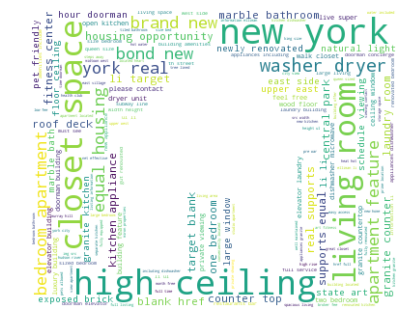

In [93]:
wordscloud_pic(text)

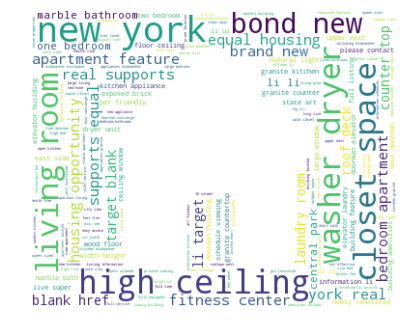

In [95]:
wordscloud_pic(text_low)

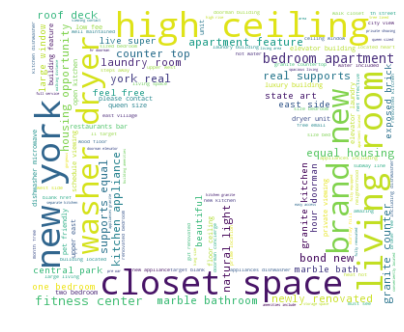

In [97]:
wordscloud_pic(text_medium)

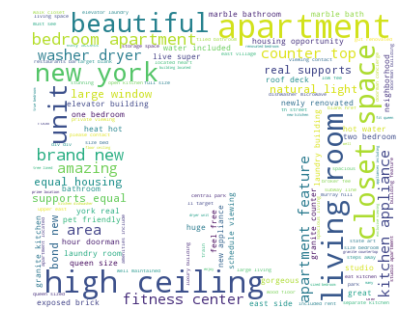

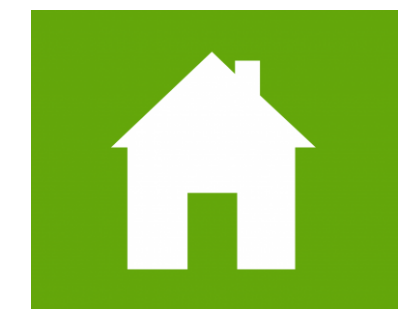

In [89]:
wordscloud_pic(text_high)

- Tansfer the text in 'description' to number

In [23]:
train_df['features'] = train_df["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
test_df['features'] = test_df["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
print(train_df["features"].head())
tfidf = CountVectorizer(stop_words='english', max_features=200)
tr_sparse = tfidf.fit_transform(train_df["features"])
te_sparse = tfidf.transform(test_df["features"])

10                                                         
10000     Doorman Elevator Fitness_Center Cats_Allowed D...
100004    Laundry_In_Building Dishwasher Hardwood_Floors...
100007                               Hardwood_Floors No_Fee
100013                                              Pre-War
Name: features, dtype: object


In [24]:
train_df.isnull().sum()

bathrooms                0
bedrooms                 0
building_id              0
created                  0
description              0
display_address          0
features                 0
interest_level           0
latitude                 0
listing_id               0
longitude                0
manager_id               0
photos                   0
price                    0
street_address           0
price_t                  0
room_sum                 0
num_photos               0
num_features             0
num_description_words    0
manager_level_low        0
manager_level_medium     0
manager_level_high       0
dtype: int64

In [25]:
train_X = sparse.hstack([train_df[features_to_use], tr_sparse]).tocsr()
test_X = sparse.hstack([test_df[features_to_use], te_sparse]).tocsr()

target_num_map = {'high':0, 'medium':1, 'low':2}
train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))
print(train_X.shape, test_X.shape)

(49352, 217) (74659, 217)


In [26]:
from sklearn.neural_network import MLPClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier 
import time as time

C:\Users\amyhu\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [27]:
train_X_d = pd.DataFrame(train_X.todense())
test_X_d = pd.DataFrame(test_X.todense())
train_y_d = pd.DataFrame(train_y)

In [28]:
def cleandata(x):
    x = x.fillna(0)
    
    x_mx = x[[5]]
    x_mx = x_mx.replace([np.inf, -np.inf], np.nan)
    mx = pd.DataFrame.max(x_mx).tolist()
    mx = str(mx[0])
    
    x[5] = x[5].apply(str)
    
    f = lambda x: float(x.replace("inf",mx)) if "inf" in x else float(x)
    
    x[5] = x[5].apply(f)
    
    return x

In [29]:
train_X_d = cleandata(train_X_d)
test_X_d = cleandata(test_X_d)

### Model Building

In [30]:
# XGBoost
model_xgb = xgb.XGBClassifier( objective= 'multi:softprob',max_depth=6,min_child_weight=1,
          subsample=0.7,colsample_bytree=0.7,learning_rate=0.3)
model_xgb.fit(train_X_d, train_y_d[0],eval_metric="mlogloss")


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.3, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.7)

XGBoost Website:
http://xgboost.readthedocs.io/en/latest/python/python_api.html

In [31]:
# Neural Network
%%time
clf_nn = MLPClassifier(solver='lbfgs', random_state=1)
params = {
    'alpha': [1e-6, 1e-5, 1e-4],
    'activation': ['tanh', 'relu', 'logistic'],
    #'hidden_layer_sizes': [(10, 30, 5) (30, 30, 5), (20, 20, 20), (30, 30, 5)]
}
gridsearchNN = GridSearchCV(clf_nn, param_grid=params, scoring='neg_log_loss', n_jobs=2, cv=5, verbose=2, refit=True) # cv=5
start = time.time()
gridsearchNN.fit(train_X_d, train_y_d[0])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  4.0min
[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed:  5.5min finished


Wall time: 5min 35s


In [32]:
#Random Forest
%%time
RF_grid = [{'max_depth': [8,9,10,11,12,13,14,15],'criterion':['gini','entropy']}]
RF = RandomForestClassifier(n_estimators=250, criterion='entropy',  n_jobs = -1,  random_state=345)
gridsearchRF = GridSearchCV(RF, RF_grid, cv=5)
gridsearchRF.fit(train_X_d, train_y_d[0])

Wall time: 11min 29s


In [33]:
#Logistic Regression
#Need long time to run this model, so for this model, we need to do feactrue selection
%%time
LREG_grid = [ {'C':[0.5,1,1.5,2],'penalty':['l1','l2']}]
LREG_classifier=LogisticRegression()
gridsearchLREG  = GridSearchCV(LREG_classifier, LREG_grid, cv=5)
gridsearchLREG.fit(train_X_d, train_y_d[0])

Wall time: 1h 13min 5s


In [34]:
#KNN
%%time
KNN_grid = [{'n_neighbors': [1,3,5,7,9,11,13,15,17], 'weights':['uniform','distance']}]
KNN=KNeighborsClassifier()
gridsearchKNN = GridSearchCV(KNN, KNN_grid, cv=5)
gridsearchKNN.fit(train_X_d, train_y_d[0])

Wall time: 16min 59s


In [36]:
#Voting
#predicts the class label based on the argmax of the sums of the predicted probabilities
%%time
eclf_1 = VotingClassifier(estimators=[
    ('KNN', gridsearchKNN), ('RF', gridsearchRF), ('LREG',gridsearchLREG),('NNW',gridsearchNN),('XGB',model_xgb)],
                        voting='soft', weights = [0.8,1,1,1.2,1.5])
eclf_1.fit(train_X_d, train_y_d[0])
y_val_pred_1 = eclf_1.predict_proba(test_X_d)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  4.1min
[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed:  5.7min finished
C:\Users\amyhu\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


Wall time: 1h 36min 11s


In [37]:
out_df_all = pd.DataFrame(y_val_pred_1)
out_df_all.columns = ["high", "medium", "low"]
out_df_all["listing_id"] = test_df.listing_id.values
out_df_all.to_csv("result_cb_5.csv", index=False)

### Future Work 
- improve based model
  1. tune parameters for each based model
  2. Do feacture selection for logistic regression or remove it
  3. New model: StackNet
  